# Unified Peptide Discovery Platform (Simulation + Assay Ingestion) 

This notebook is a single, end-to-end, non-redundant proof-of-concept for **closed-loop peptide design**:

1. **Design** candidate peptides (mutation + crossover).
2. **Predict** three objectives using surrogate ML models with uncertainty,
   **Affinity**, **Stability**, **Solubility** (maximize all three).
3. **Prioritize** candidates using a Bayesian-style acquisition function (UCB, EI, or EHVI-lite).
4. **Gate** candidates using manufacturability and chemical-liability rules.
5. **Diversify** the final batch (Levenshtein distance or a fast proxy).
6. **Export** CRO-ready artifacts,
   proposed candidates (CSV), synthesis order sheet (CSV), plate map (CSV + PNG),
   screening decision report (Top50 CSV).
7. Optional, **REAL assay ingestion + QC** (dose–response or single-point),
   replicate CV flags, plate Z′ factor if controls exist,
   4-parameter logistic (4PL) fit without SciPy.

## Dependencies
`numpy`, `pandas`, `matplotlib`, `scikit-learn` (CPU-only).

> Outputs are written to the folder you choose in CONFIG.


## 1. Setup and configuration

Edit the config below to choose mode and parameters.
In assay mode, provide file paths to your CSVs.


In [3]:
# CONFIG (edit these)

CONFIG = {
    "OUTDIR": "out_iso_peptides_notebook",
    "ASSAY_MODE": False,

    # Required if ASSAY_MODE=True
    "ASSAY_CSV": None,  # e.g. "assay_primary.csv"

    # Optional
    "STABILITY_CSV": None,  # e.g. "assay_stability.csv"
    "SOLUBILITY_CSV": None,  # e.g. "assay_solubility.csv"

    "SEED": 7,

    "LIBRARY_SIZE": 7000,
    "INITIAL_MEASURED": 80,
    "PROPOSE_PER_ROUND": 48,
    "ROUNDS": 8,
    "LENGTH_MIN": 10,
    "LENGTH_MAX": 20,

    "USE_KMERS": True,
    "FAST_DIVERSITY": False,
    "MIN_LEV_DIST": 3,

    "ACQ": "UCB",  # "UCB", "EI", "EHVI"

    "MAX_LIABILITY_FLAGS": 2,
    "N_MODELS": 5,
}


In [5]:
from __future__ import annotations

import os, math, json, random
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401


In [7]:
# Helpers

AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

HYDROPATHY = {
    "A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3
}

CHARGE = {"D": -1, "E": -1, "K": +1, "R": +1, "H": +0.1}

AROMATIC = set("FWY")
POLAR = set("STNQH")
HYDROPHOBIC = set("AILMVFWY")

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)

def safe_mkdir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def sigmoid(x: float) -> float:
    return 1.0 / (1.0 + math.exp(-x))

def clamp(x: float, lo: float, hi: float) -> float:
    return float(np.clip(x, lo, hi))

def save_plot(fig: plt.Figure, outpath: str) -> None:
    fig.tight_layout()
    fig.savefig(outpath, dpi=220)
    plt.close(fig)


# 2) Sequence generation and operators

In [9]:
def random_peptide(length: int) -> str:
    return "".join(random.choice(AMINO_ACIDS) for _ in range(length))

def generate_library(n: int, length_range: Tuple[int, int]) -> List[str]:
    return [random_peptide(random.randint(*length_range)) for _ in range(n)]

def mutate_peptide(seq: str, n_mutations: int = 1) -> str:
    seq_list = list(seq)
    if len(seq_list) == 0:
        return seq
    idxs = np.random.choice(len(seq_list), size=min(n_mutations, len(seq_list)), replace=False)
    for i in idxs:
        original = seq_list[i]
        choices = [aa for aa in AMINO_ACIDS if aa != original]
        seq_list[i] = random.choice(choices)
    return "".join(seq_list)

def crossover(a: str, b: str) -> str:
    if len(a) != len(b) or len(a) < 6:
        return a
    cut = random.randint(2, len(a) - 3)
    return a[:cut] + b[cut:]

def diversify_candidates(cands: List[str], max_keep: int = 50000) -> List[str]:
    unique = list(dict.fromkeys(cands))
    return unique[:max_keep]


# 3) Diversity constraints

In [11]:
def levenshtein(a: str, b: str) -> int:
    if a == b:
        return 0
    la, lb = len(a), len(b)
    if la == 0:
        return lb
    if lb == 0:
        return la
    if la < lb:
        a, b = b, a
        la, lb = lb, la

    prev = list(range(lb + 1))
    for i in range(1, la + 1):
        cur = [i] + [0] * lb
        ca = a[i - 1]
        for j in range(1, lb + 1):
            cb = b[j - 1]
            ins = cur[j - 1] + 1
            dele = prev[j] + 1
            sub = prev[j - 1] + (0 if ca == cb else 1)
            cur[j] = min(ins, dele, sub)
        prev = cur
    return prev[-1]

def greedy_diverse_selection(df: pd.DataFrame, k: int, min_lev_dist: int = 3, fast: bool = False) -> pd.DataFrame:
    chosen_rows = []
    chosen_seqs: List[str] = []

    for _, row in df.iterrows():
        s = row["sequence"]
        if not chosen_seqs:
            chosen_rows.append(row)
            chosen_seqs.append(s)
        else:
            ok = True
            for cs in chosen_seqs:
                if fast:
                    if len(s) != len(cs):
                        if abs(len(s) - len(cs)) < 2:
                            ok = False
                            break
                    else:
                        mism = sum(1 for x, y in zip(s, cs) if x != y)
                        if mism < min_lev_dist:
                            ok = False
                            break
                else:
                    if levenshtein(s, cs) < min_lev_dist:
                        ok = False
                        break
            if ok:
                chosen_rows.append(row)
                chosen_seqs.append(s)

        if len(chosen_rows) >= k:
            break

    if not chosen_rows:
        return df.head(k).copy()
    return pd.DataFrame(chosen_rows).reset_index(drop=True)


# 4) Feature engineering (sequence -> numeric)

In [13]:
def net_charge(seq: str) -> float:
    return float(sum(CHARGE.get(a, 0.0) for a in seq))

def aromatic_fraction(seq: str) -> float:
    return float(sum(1 for a in seq if a in AROMATIC) / max(1, len(seq)))

def hydrophobic_fraction(seq: str) -> float:
    return float(sum(1 for a in seq if a in HYDROPHOBIC) / max(1, len(seq)))

def polar_fraction(seq: str) -> float:
    return float(sum(1 for a in seq if a in POLAR) / max(1, len(seq)))

def aa_composition(seq: str) -> np.ndarray:
    counts = np.array([seq.count(a) for a in AMINO_ACIDS], dtype=float)
    return counts / max(1, len(seq))

def sliding_hydrophobic_windows(seq: str, win: int = 5) -> float:
    if len(seq) < win:
        return 0.0
    vals = []
    for i in range(len(seq) - win + 1):
        window = seq[i:i + win]
        vals.append(np.mean([HYDROPATHY[x] for x in window]))
    return float(max(vals))

def helix_propensity_proxy(seq: str) -> float:
    helix_pos = set("ALEKM")
    good = sum(1 for a in seq if a in helix_pos) / max(1, len(seq))
    bad = (seq.count("P") + seq.count("G")) / max(1, len(seq))
    return float(good - 1.2 * bad)

def hydrophobic_moment_proxy(seq: str) -> float:
    x = np.array([HYDROPATHY[a] for a in seq], dtype=float)
    if len(x) < 6:
        return 0.0

    def corr(lag: int) -> float:
        a = x[:-lag]
        b = x[lag:]
        return float(np.mean(a * b))

    return 0.5 * (corr(3) + corr(4))

def motif_counts(seq: str) -> Dict[str, int]:
    motifs = {"RGD": 0, "FYF": 0, "WxxW": 0, "KxxK": 0}
    motifs["RGD"] = sum(1 for i in range(len(seq) - 2) if seq[i:i + 3] == "RGD")
    motifs["FYF"] = sum(1 for i in range(len(seq) - 2) if seq[i:i + 3] == "FYF")
    motifs["WxxW"] = sum(1 for i in range(len(seq) - 3) if seq[i] == "W" and seq[i + 3] == "W")
    motifs["KxxK"] = sum(1 for i in range(len(seq) - 3) if seq[i] == "K" and seq[i + 3] == "K")
    return motifs

def physchem_features(seq: str) -> np.ndarray:
    L = len(seq)
    hydro = np.array([HYDROPATHY[a] for a in seq], dtype=float)
    q = net_charge(seq)
    motifs = motif_counts(seq)
    feats = [
        float(L),
        float(np.mean(hydro)),
        float(np.std(hydro)),
        float(np.max(hydro)),
        float(np.min(hydro)),
        float(sliding_hydrophobic_windows(seq, win=5)),
        float(q),
        float(abs(q)),
        float(aromatic_fraction(seq)),
        float(hydrophobic_fraction(seq)),
        float(polar_fraction(seq)),
        float(seq.count("P") / max(1, L)),
        float(seq.count("G") / max(1, L)),
        float(seq.count("C") / max(1, L)),
        float(seq.count("M") / max(1, L)),
        float(seq.count("W") / max(1, L)),
        float(helix_propensity_proxy(seq)),
        float(hydrophobic_moment_proxy(seq)),
        float(motifs["RGD"]),
        float(motifs["FYF"]),
        float(motifs["WxxW"]),
        float(motifs["KxxK"]),
    ]
    return np.array(feats, dtype=float)

def kmer_counts(seq: str, k: int = 2, vocab: Optional[List[str]] = None) -> np.ndarray:
    if vocab is None:
        vocab = [a + b for a in AMINO_ACIDS for b in AMINO_ACIDS]
    idx = {v: i for i, v in enumerate(vocab)}
    vec = np.zeros(len(vocab), dtype=float)
    if len(seq) < k:
        return vec
    for i in range(len(seq) - k + 1):
        km = seq[i:i + k]
        if km in idx:
            vec[idx[km]] += 1.0
    vec = vec / max(1.0, (len(seq) - k + 1))
    return vec

def featurize(seqs: List[str], use_kmers: bool = True) -> np.ndarray:
    vocab2 = [a + b for a in AMINO_ACIDS for b in AMINO_ACIDS] if use_kmers else None
    X = []
    for s in seqs:
        parts = [aa_composition(s), physchem_features(s)]
        if use_kmers:
            parts.append(kmer_counts(s, k=2, vocab=vocab2))
        X.append(np.concatenate(parts))
    return np.vstack(X)


# 5) Liabilities / manufacturability gates

In [15]:
@dataclass
class LiabilityConfig:
    max_cys: int = 1
    max_met: int = 2
    max_trp: int = 2
    max_abs_charge: float = 4.0
    max_hydrophobic_fraction: float = 0.65
    max_aromatic_fraction: float = 0.30
    disallow_motifs: Tuple[str, ...] = ("NG", "NS", "QG", "QN", "DP")

def liability_flags(seq: str, cfg: LiabilityConfig) -> Dict[str, float]:
    flags: Dict[str, float] = {}
    flags["flag_deamidation_hotspot"] = float(any(m in seq for m in ("NG", "NS", "QG", "QN")))
    flags["flag_asp_pro_cleavage"] = float("DP" in seq)
    flags["flag_oxidation_risk"] = float(seq.count("M") > cfg.max_met or seq.count("W") > cfg.max_trp)
    flags["flag_cysteine_risk"] = float(seq.count("C") > cfg.max_cys)
    flags["flag_extreme_charge"] = float(abs(net_charge(seq)) > cfg.max_abs_charge)

    hyd = hydrophobic_fraction(seq)
    aro = aromatic_fraction(seq)
    flags["flag_aggregation_risk"] = float((hyd > cfg.max_hydrophobic_fraction) or (aro > cfg.max_aromatic_fraction))

    flags["liability_count"] = float(sum(flags[k] for k in flags if k.startswith("flag_")))
    flags["length"] = float(len(seq))
    flags["net_charge"] = float(net_charge(seq))
    flags["hydrophobic_fraction"] = float(hyd)
    flags["aromatic_fraction"] = float(aro)
    return flags

def liability_score(seq: str, cfg: LiabilityConfig) -> float:
    f = liability_flags(seq, cfg)
    penalty = (
        1.4 * f["flag_deamidation_hotspot"] +
        1.2 * f["flag_asp_pro_cleavage"] +
        1.0 * f["flag_oxidation_risk"] +
        1.2 * f["flag_cysteine_risk"] +
        0.9 * f["flag_extreme_charge"] +
        1.1 * f["flag_aggregation_risk"]
    )
    return float(penalty)

def pass_liability_gate(seq: str, cfg: LiabilityConfig, max_flags: int = 2) -> bool:
    f = liability_flags(seq, cfg)
    return int(f["liability_count"]) <= max_flags


# 6) Oracle (simulation "truth") for demo mode

In [17]:
@dataclass
class OracleWeights:
    motif_bonus: float = 2.4
    hydrophobic_window_bonus: float = 1.1
    length_optimum: int = 14
    length_penalty: float = 0.06
    sbdd_bonus: float = 0.9

def oracle(seq: str, w: OracleWeights = OracleWeights(), noise: float = 0.15) -> Dict[str, float]:
    motifs = motif_counts(seq)
    motif_hits = motifs["RGD"] + motifs["FYF"] + motifs["WxxW"] + motifs["KxxK"]

    L = len(seq)
    hydro_win = sliding_hydrophobic_windows(seq, win=5)
    qabs = abs(net_charge(seq))
    cys = seq.count("C")
    pro = seq.count("P")
    aro = aromatic_fraction(seq)
    hyd = hydrophobic_fraction(seq)

    sbdd = helix_propensity_proxy(seq) + 0.35 * hydrophobic_moment_proxy(seq)

    affinity = (
        1.0
        + w.motif_bonus * motif_hits
        + w.hydrophobic_window_bonus * max(0.0, hydro_win)
        + w.sbdd_bonus * sbdd
        - 0.30 * (hyd > 0.62) * (hyd - 0.62) * 10
        - w.length_penalty * (L - w.length_optimum) ** 2
    )

    stability = (
        1.0
        + 0.9 * (1.0 - qabs / max(1.0, L / 2))
        - 0.70 * (pro / max(1, L))
        - 1.00 * (cys / max(1, L))
        + 0.35 * (0.25 <= hyd <= 0.55)
        + 0.25 * sbdd
    )

    solubility = (
        1.0
        + 0.95 * polar_fraction(seq)
        - 0.95 * aro
        - 0.85 * max(0.0, hyd - 0.55) * 2.0
        + 0.15 * (qabs > 1.0)
        - 0.2 * max(0.0, sbdd - 0.75)
    )

    affinity += np.random.normal(0, noise)
    stability += np.random.normal(0, noise)
    solubility += np.random.normal(0, noise)

    affinity = clamp(affinity, -2.0, 14.0)
    stability = clamp(stability, -1.0, 5.0)
    solubility = clamp(solubility, -1.0, 5.0)

    return {"affinity": affinity, "stability": stability, "solubility": solubility}

def measure_sequences_oracle(seqs: List[str]) -> pd.DataFrame:
    rows = []
    for s in seqs:
        out = oracle(s)
        rows.append({"sequence": s, **out})
    return pd.DataFrame(rows)


# 7) Pareto front + ML surrogates with uncertainty

In [19]:
def pareto_front(df: pd.DataFrame, objectives: List[str]) -> pd.Series:
    vals = df[objectives].values
    n = vals.shape[0]
    is_pareto = np.ones(n, dtype=bool)
    for i in range(n):
        if not is_pareto[i]:
            continue
        dominates = np.all(vals >= vals[i], axis=1) & np.any(vals > vals[i], axis=1)
        if np.any(dominates):
            is_pareto[i] = False
    return pd.Series(is_pareto, index=df.index)

def fit_model(X: np.ndarray, y: np.ndarray, seed: int) -> Pipeline:
    rf = RandomForestRegressor(
        n_estimators=450,
        random_state=seed,
        min_samples_leaf=2,
        n_jobs=-1
    )
    pipe = Pipeline([("scaler", StandardScaler()), ("rf", rf)])
    pipe.fit(X, y)
    return pipe

def train_ensemble(X: np.ndarray, y: np.ndarray, seed: int, n_models: int = 5) -> List[Pipeline]:
    models = []
    for i in range(n_models):
        rng = np.random.default_rng(seed + i)
        idx = rng.choice(len(X), size=len(X), replace=True)
        models.append(fit_model(X[idx], y[idx], seed=seed + i))
    return models

def ensemble_predict(models: List[Pipeline], X: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    preds = np.vstack([m.predict(X) for m in models])
    return preds.mean(axis=0), preds.std(axis=0)


# 8) Acquisition functions (BO-like)

In [21]:
def ucb(mu: np.ndarray, sigma: np.ndarray, beta: float = 1.8) -> np.ndarray:
    return mu + beta * sigma

def expected_improvement(mu: np.ndarray, sigma: np.ndarray, best: float, xi: float = 0.02) -> np.ndarray:
    sigma = np.maximum(sigma, 1e-9)
    z = (mu - best - xi) / sigma
    Phi = 0.5 * (1.0 + np.erf(z / np.sqrt(2)))
    phi = (1.0 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * z**2)
    ei = (mu - best - xi) * Phi + sigma * phi
    return np.maximum(ei, 0.0)

def multiobjective_acq(mu: Dict[str, np.ndarray], sd: Dict[str, np.ndarray], measured_df: pd.DataFrame, acq: str, weights: Dict[str, float]) -> np.ndarray:
    comp_mu = np.zeros_like(next(iter(mu.values())))
    comp_var = np.zeros_like(next(iter(sd.values())))
    for k, w in weights.items():
        comp_mu += w * mu[k]
        comp_var += (w ** 2) * (sd[k] ** 2)
    comp_sd = np.sqrt(comp_var)

    acq_u = acq.upper()
    if acq_u == "UCB":
        return ucb(comp_mu, comp_sd, beta=1.8)

    if acq_u == "EI":
        m = measured_df.copy()
        m["comp"] = weights["affinity"] * m["affinity"] + weights["stability"] * m["stability"] + weights["solubility"] * m["solubility"]
        best = float(m["comp"].max())
        return expected_improvement(comp_mu, comp_sd, best=best, xi=0.02)

    balance = 0.5 * sigmoid(mu["stability"] - 1.1) + 0.5 * sigmoid(mu["solubility"] - 1.0)
    return ucb(comp_mu, comp_sd, beta=1.6) * (0.7 + 0.7 * balance)


# 9) Proposal generation and closed-loop config

In [23]:
@dataclass
class Config:
    seed: int = 7
    library_size: int = 7000
    initial_measured: int = 80
    propose_per_round: int = 48
    rounds: int = 8
    length_min: int = 10
    length_max: int = 20
    kmers: bool = True
    mutations_per_candidate: int = 2
    crossover_rate: float = 0.18
    min_lev_dist: int = 3
    fast: bool = False
    acq: str = "UCB"
    max_liability_flags: int = 2
    n_elites: int = 40
    n_models: int = 5

def expand_pool_from_elites(measured_df: pd.DataFrame, cfg: Config) -> List[str]:
    df = measured_df.copy()
    df["elite_score"] = 1.0 * df["affinity"] + 0.8 * df["stability"] + 0.6 * df["solubility"]
    elites = df.sort_values("elite_score", ascending=False).head(cfg.n_elites)["sequence"].tolist()

    props: List[str] = []
    for e in elites:
        for _ in range(12):
            props.append(mutate_peptide(e, n_mutations=cfg.mutations_per_candidate))
        if random.random() < cfg.crossover_rate:
            partner = random.choice(elites)
            props.append(crossover(e, partner))
    return diversify_candidates(props, max_keep=50000)

def propose_candidates(measured_df: pd.DataFrame, pool_seqs: List[str], cfg: Config, weights: Dict[str, float], lcfg: LiabilityConfig) -> pd.DataFrame:
    measured_seqs = measured_df["sequence"].tolist()
    X_meas = featurize(measured_seqs, use_kmers=cfg.kmers)

    models: Dict[str, List[Pipeline]] = {}
    mu: Dict[str, np.ndarray] = {}
    sd: Dict[str, np.ndarray] = {}

    for obj in ["affinity", "stability", "solubility"]:
        y = measured_df[obj].values
        models[obj] = train_ensemble(X_meas, y, seed=cfg.seed + (hash(obj) % 999), n_models=cfg.n_models)

    measured_set = set(measured_seqs)
    remaining = [s for s in pool_seqs if s not in measured_set]
    if len(remaining) == 0:
        return pd.DataFrame(columns=["sequence"])

    X_pool = featurize(remaining, use_kmers=cfg.kmers)
    for obj in ["affinity", "stability", "solubility"]:
        mu[obj], sd[obj] = ensemble_predict(models[obj], X_pool)

    acq_vals = multiobjective_acq(mu, sd, measured_df, acq=cfg.acq, weights=weights)

    penalties = np.array([liability_score(s, lcfg) for s in remaining], dtype=float)
    penalized_acq = acq_vals - 0.85 * penalties

    prop = pd.DataFrame({
        "sequence": remaining,
        "pred_affinity": mu["affinity"],
        "pred_stability": mu["stability"],
        "pred_solubility": mu["solubility"],
        "sd_affinity": sd["affinity"],
        "sd_stability": sd["stability"],
        "sd_solubility": sd["solubility"],
        "liability_penalty": penalties,
        "acq_score": penalized_acq
    }).sort_values("acq_score", ascending=False)

    prop["pass_gate"] = prop["sequence"].apply(lambda s: pass_liability_gate(s, lcfg, max_flags=cfg.max_liability_flags))
    gated = prop[prop["pass_gate"]].copy()
    if len(gated) < cfg.propose_per_round:
        gated = prop.copy()

    diverse = greedy_diverse_selection(gated, k=cfg.propose_per_round, min_lev_dist=cfg.min_lev_dist, fast=cfg.fast)
    flags_df = pd.DataFrame([liability_flags(s, lcfg) for s in diverse["sequence"].tolist()])
    return pd.concat([diverse.reset_index(drop=True), flags_df.reset_index(drop=True)], axis=1)


# 10) CRO artifacts: order sheet + plate map

In [25]:
def make_96well_map(seqs: List[str]) -> pd.DataFrame:
    rows = list("ABCDEFGH")
    cols = list(range(1, 13))
    plate = pd.DataFrame("", index=rows, columns=cols)
    i = 0
    for r in rows:
        for c in cols:
            if i < len(seqs):
                plate.loc[r, c] = f"Pep_{i+1:03d}"
            i += 1
    return plate

def save_plate_map_png(plate_df: pd.DataFrame, outpath: str, title: str = "96-well plate map") -> None:
    fig = plt.figure(figsize=(10.5, 4.8))
    ax = fig.add_subplot(111)
    ax.axis("off")
    tbl = ax.table(cellText=plate_df.values, rowLabels=plate_df.index, colLabels=[str(c) for c in plate_df.columns], loc="center")
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(8)
    tbl.scale(1.0, 1.25)
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(outpath, dpi=220)
    plt.close(fig)

def build_synthesis_order_sheet(proposal_df: pd.DataFrame, outdir: str, prefix: str, default_purity: str = ">=95% (HPLC)", default_scale: str = "5 mg", default_mods: str = "None") -> pd.DataFrame:
    df = proposal_df.copy().reset_index(drop=True)
    df.insert(0, "peptide_id", [f"Pep_{i+1:03d}" for i in range(len(df))])
    df["purity_spec"] = default_purity
    df["synthesis_scale"] = default_scale
    df["modifications"] = default_mods
    df["notes"] = df.apply(lambda r: f"Liabilities={int(r['liability_count'])}, charge={r['net_charge']:.1f}", axis=1)

    cols = [
        "peptide_id", "sequence", "length", "modifications",
        "synthesis_scale", "purity_spec",
        "pred_affinity", "pred_stability", "pred_solubility",
        "acq_score",
        "liability_count",
        "flag_deamidation_hotspot",
        "flag_asp_pro_cleavage",
        "flag_oxidation_risk",
        "flag_cysteine_risk",
        "flag_extreme_charge",
        "flag_aggregation_risk",
        "notes"
    ]
    df = df[cols]
    df.to_csv(os.path.join(outdir, f"{prefix}_synthesis_order_sheet.csv"), index=False)
    return df


# 11) Plotting

In [27]:
def plot_distributions(measured_df: pd.DataFrame, outdir: str) -> None:
    for col in ["affinity", "stability", "solubility"]:
        fig = plt.figure(figsize=(7.8, 5.5))
        ax = fig.add_subplot(111)
        ax.hist(measured_df[col], bins=30, alpha=0.7)
        ax.set_xlabel(col.capitalize())
        ax.set_ylabel("Count")
        ax.set_title(f"Measured distribution: {col}")
        save_plot(fig, os.path.join(outdir, f"fig_dist_{col}.png"))

def plot_pareto_2d(measured_df: pd.DataFrame, outdir: str, r: int) -> None:
    df = measured_df.copy()
    df["pareto"] = pareto_front(df, ["affinity", "stability", "solubility"])

    fig = plt.figure(figsize=(7.8, 5.5))
    ax = fig.add_subplot(111)
    ax.scatter(df["stability"], df["affinity"], alpha=0.5)
    ax.scatter(df.loc[df["pareto"], "stability"], df.loc[df["pareto"], "affinity"], alpha=0.95)
    ax.set_xlabel("Stability (higher better)")
    ax.set_ylabel("Affinity (higher better)")
    ax.set_title(f"Round {r}: Affinity vs Stability (Pareto highlighted)")
    save_plot(fig, os.path.join(outdir, f"fig_round{r:02d}_pareto_2d.png"))

def plot_pareto_3d(measured_df: pd.DataFrame, outdir: str, r: int) -> None:
    df = measured_df.copy()
    df["pareto"] = pareto_front(df, ["affinity", "stability", "solubility"])

    fig = plt.figure(figsize=(8.2, 6.0))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df["stability"], df["solubility"], df["affinity"], alpha=0.45)
    ax.scatter(df.loc[df["pareto"], "stability"], df.loc[df["pareto"], "solubility"], df.loc[df["pareto"], "affinity"], alpha=0.95)
    ax.set_xlabel("Stability")
    ax.set_ylabel("Solubility")
    ax.set_zlabel("Affinity")
    ax.set_title(f"Round {r}: 3D Pareto landscape")
    save_plot(fig, os.path.join(outdir, f"fig_round{r:02d}_pareto_3d.png"))

def plot_learning(history_df: pd.DataFrame, outdir: str) -> None:
    fig = plt.figure(figsize=(7.8, 5.5))
    ax = fig.add_subplot(111)
    ax.plot(history_df["n_measured"], history_df["best_affinity"], marker="o")
    ax.plot(history_df["n_measured"], history_df["best_composite"], marker="o")
    ax.set_xlabel("Measured peptides (cumulative)")
    ax.set_ylabel("Best score")
    ax.set_title("Closed-loop learning: best affinity and best composite score")
    ax.legend(["Best affinity", "Best composite"], loc="best")
    save_plot(fig, os.path.join(outdir, "fig_learning_curve.png"))


# 12) Screening decision report

In [29]:
def make_screening_report(measured_df: pd.DataFrame, outdir: str, lcfg: LiabilityConfig, topn: int = 50) -> pd.DataFrame:
    df = measured_df.copy()
    df["composite"] = 1.0 * df["affinity"] + 0.8 * df["stability"] + 0.6 * df["solubility"]
    df["pareto"] = pareto_front(df, ["affinity", "stability", "solubility"])

    flags_df = pd.DataFrame([liability_flags(s, lcfg) for s in df["sequence"].tolist()])
    df = pd.concat([df.reset_index(drop=True), flags_df.reset_index(drop=True)], axis=1)

    rep = df.sort_values(["composite", "pareto"], ascending=False).head(topn).reset_index(drop=True)
    rep.to_csv(os.path.join(outdir, "screening_report_top50.csv"), index=False)
    return rep


# 13) REAL assay ingestion + QC (optional)

In [31]:
def zprime(pos: np.ndarray, neg: np.ndarray) -> float:
    pos = np.asarray(pos, dtype=float)
    neg = np.asarray(neg, dtype=float)
    if len(pos) < 2 or len(neg) < 2:
        return float("nan")
    mu_p, mu_n = pos.mean(), neg.mean()
    sd_p, sd_n = pos.std(ddof=1), neg.std(ddof=1)
    denom = abs(mu_p - mu_n) + 1e-12
    return float(1.0 - (3.0 * (sd_p + sd_n) / denom))

def robust_mean(x: np.ndarray, trim_frac: float = 0.10) -> float:
    x = np.sort(np.asarray(x, dtype=float))
    n = len(x)
    if n == 0:
        return float("nan")
    k = int(math.floor(n * trim_frac))
    x2 = x[k:n - k] if n - 2 * k > 0 else x
    return float(np.mean(x2))

def cv_percent(x: np.ndarray) -> float:
    x = np.asarray(x, dtype=float)
    if len(x) < 2:
        return float("nan")
    mu = np.mean(x)
    sd = np.std(x, ddof=1)
    return float(100.0 * sd / (abs(mu) + 1e-12))

def four_pl(x: np.ndarray, bottom: float, top: float, logIC50: float, hill: float) -> np.ndarray:
    x = np.asarray(x, dtype=float)
    ic50 = 10.0 ** float(logIC50)
    return bottom + (top - bottom) / (1.0 + (x / (ic50 + 1e-12)) ** (hill + 1e-12))

def fit_4pl_grid(x: np.ndarray, y: np.ndarray) -> Dict[str, float]:
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    if len(np.unique(x)) < 4:
        return {"bottom": float(np.min(y)), "top": float(np.max(y)), "logIC50": float(np.log10(np.median(x) + 1e-12)), "hill": 1.0, "rmse": float(np.sqrt(np.mean((y - np.mean(y)) ** 2)))}

    y_low = np.mean(y[x == np.min(x)]) if np.any(x == np.min(x)) else np.max(y)
    y_high = np.mean(y[x == np.max(x)]) if np.any(x == np.max(x)) else np.min(y)
    bottom0 = float(min(y_low, y_high))
    top0 = float(max(y_low, y_high))

    logx = np.log10(x + 1e-12)
    logIC50_grid = np.linspace(np.min(logx) - 1.0, np.max(logx) + 1.0, 40)
    hill_grid = np.linspace(0.6, 2.4, 20)

    best = {"rmse": float("inf"), "bottom": bottom0, "top": top0, "logIC50": 0.0, "hill": 1.0}
    for logIC50 in logIC50_grid:
        for hill in hill_grid:
            pred = four_pl(x, bottom0, top0, logIC50, hill)
            rmse = float(np.sqrt(np.mean((y - pred) ** 2)))
            if rmse < best["rmse"]:
                best = {"rmse": rmse, "bottom": bottom0, "top": top0, "logIC50": float(logIC50), "hill": float(hill)}

    rng = np.random.default_rng(123)
    for _ in range(250):
        logIC50 = best["logIC50"] + rng.normal(0, 0.12)
        hill = clamp(best["hill"] + rng.normal(0, 0.12), 0.4, 4.0)
        bottom = best["bottom"] + rng.normal(0, 0.05 * (np.std(y) + 1e-12))
        top = best["top"] + rng.normal(0, 0.05 * (np.std(y) + 1e-12))
        pred = four_pl(x, bottom, top, logIC50, hill)
        rmse = float(np.sqrt(np.mean((y - pred) ** 2)))
        if rmse < best["rmse"]:
            best = {"rmse": rmse, "bottom": float(bottom), "top": float(top), "logIC50": float(logIC50), "hill": float(hill)}
    return best

def ingest_primary_assay_csv(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"peptide_id", "concentration_uM", "response", "replicate"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"Primary assay CSV missing required columns: {sorted(missing)}")

    df["peptide_id"] = df["peptide_id"].astype(str)
    df["concentration_uM"] = df["concentration_uM"].astype(float)
    df["response"] = df["response"].astype(float)
    df["replicate"] = df["replicate"].astype(int)

    for col in ["plate_id", "well", "assay_name"]:
        if col not in df.columns:
            df[col] = "NA"

    for col in ["is_pos_ctrl", "is_neg_ctrl"]:
        if col not in df.columns:
            df[col] = False
        df[col] = df[col].astype(bool)

    return df

def summarize_primary_assay(primary_raw: pd.DataFrame, max_cv: float = 25.0) -> Tuple[pd.DataFrame, pd.DataFrame]:
    df = primary_raw.copy()

    plate_rows = []
    for plate_id, g in df.groupby("plate_id", dropna=False):
        pos = g.loc[g["is_pos_ctrl"], "response"].values
        neg = g.loc[g["is_neg_ctrl"], "response"].values
        z = zprime(pos, neg) if (len(pos) > 1 and len(neg) > 1) else float("nan")
        plate_rows.append({"plate_id": plate_id, "zprime": z, "n_pos": len(pos), "n_neg": len(neg)})
    plate_qc = pd.DataFrame(plate_rows)

    summaries = []
    for pep, g in df.groupby("peptide_id"):
        x = g["concentration_uM"].values
        y = g["response"].values

        cv_by_conc = []
        for c, gc in g.groupby("concentration_uM"):
            if len(gc) >= 2:
                cv_by_conc.append(cv_percent(gc["response"].values))
        cv_med = float(np.nanmedian(cv_by_conc)) if len(cv_by_conc) else float("nan")
        cv_flag = int((not np.isnan(cv_med)) and (cv_med > max_cv))

        unique_conc = np.unique(x)
        if len(unique_conc) >= 4:
            fit = fit_4pl_grid(x, y)
            ic50 = 10.0 ** fit["logIC50"]
            pic50 = -math.log10(ic50 + 1e-12)
            summaries.append({"peptide_id": pep, "mode": "dose_response", "IC50_uM": float(ic50), "pIC50_uM": float(pic50), "affinity": float(pic50), "fit_rmse": float(fit["rmse"]), "hill": float(fit["hill"]), "top": float(fit["top"]), "bottom": float(fit["bottom"]), "replicate_cv_median_percent": cv_med, "flag_high_cv": cv_flag})
        else:
            mean_resp = robust_mean(y, trim_frac=0.10)
            summaries.append({"peptide_id": pep, "mode": "single_point", "IC50_uM": float("nan"), "pIC50_uM": float("nan"), "affinity": float(mean_resp), "fit_rmse": float("nan"), "hill": float("nan"), "top": float("nan"), "bottom": float("nan"), "replicate_cv_median_percent": cv_med, "flag_high_cv": cv_flag})

    return pd.DataFrame(summaries), plate_qc

def ingest_scalar_assay(path: str, value_col: str, name: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    required = {"peptide_id", value_col, "replicate"}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(f"{name} CSV missing required columns: {sorted(missing)}")

    df["peptide_id"] = df["peptide_id"].astype(str)
    df[value_col] = df[value_col].astype(float)
    df["replicate"] = df["replicate"].astype(int)
    return df

def summarize_scalar_assay(df: pd.DataFrame, value_col: str, max_cv: float = 25.0) -> pd.DataFrame:
    rows = []
    for pep, g in df.groupby("peptide_id"):
        vals = g[value_col].values
        m = robust_mean(vals, trim_frac=0.10)
        cv = cv_percent(vals) if len(vals) >= 2 else float("nan")
        rows.append({"peptide_id": pep, value_col: float(m), f"{value_col}_cv_percent": float(cv), f"flag_{value_col}_high_cv": int((not np.isnan(cv)) and (cv > max_cv))})
    return pd.DataFrame(rows)

def build_measured_table_from_assays(proposal_table: pd.DataFrame, primary_summary: pd.DataFrame, stability_summary: Optional[pd.DataFrame] = None, solubility_summary: Optional[pd.DataFrame] = None) -> pd.DataFrame:
    df = proposal_table.copy()
    if "peptide_id" not in df.columns:
        df = df.reset_index(drop=True)
        df.insert(0, "peptide_id", [f"Pep_{i+1:03d}" for i in range(len(df))])

    merged = df.merge(primary_summary[["peptide_id", "affinity"]], on="peptide_id", how="left")

    if stability_summary is not None and "stability_score" in stability_summary.columns:
        merged = merged.merge(stability_summary[["peptide_id", "stability_score"]], on="peptide_id", how="left").rename(columns={"stability_score": "stability"})
    else:
        merged["stability"] = 1.0

    if solubility_summary is not None and "solubility_score" in solubility_summary.columns:
        merged = merged.merge(solubility_summary[["peptide_id", "solubility_score"]], on="peptide_id", how="left").rename(columns={"solubility_score": "solubility"})
    else:
        merged["solubility"] = 1.0

    merged = merged.dropna(subset=["affinity"]).copy()
    merged["affinity"] = merged["affinity"].astype(float)
    merged["stability"] = merged["stability"].astype(float)
    merged["solubility"] = merged["solubility"].astype(float)
    return merged


## 14. Run the platform

Run this cell to execute the chosen mode and write all artifacts to `CONFIG["OUTDIR"]`.


In [34]:
# Run
set_seed(CONFIG["SEED"])
safe_mkdir(CONFIG["OUTDIR"])

cfg = Config(
    seed=CONFIG["SEED"],
    library_size=CONFIG["LIBRARY_SIZE"],
    initial_measured=CONFIG["INITIAL_MEASURED"],
    propose_per_round=CONFIG["PROPOSE_PER_ROUND"],
    rounds=CONFIG["ROUNDS"],
    length_min=CONFIG["LENGTH_MIN"],
    length_max=CONFIG["LENGTH_MAX"],
    kmers=bool(CONFIG["USE_KMERS"]),
    fast=bool(CONFIG["FAST_DIVERSITY"]),
    min_lev_dist=int(CONFIG["MIN_LEV_DIST"]),
    acq=str(CONFIG["ACQ"]),
    max_liability_flags=int(CONFIG["MAX_LIABILITY_FLAGS"]),
    n_models=int(CONFIG["N_MODELS"]),
)

weights = {"affinity": 1.0, "stability": 0.8, "solubility": 0.6}
lcfg = LiabilityConfig()

base = generate_library(cfg.library_size, (cfg.length_min, cfg.length_max))
base = diversify_candidates(base, max_keep=cfg.library_size)

if CONFIG["ASSAY_MODE"]:
    if not CONFIG["ASSAY_CSV"]:
        raise ValueError("ASSAY_MODE=True but ASSAY_CSV is None. Provide the path to your primary assay CSV.")

    primary_raw = ingest_primary_assay_csv(CONFIG["ASSAY_CSV"])
    primary_summary, plate_qc = summarize_primary_assay(primary_raw, max_cv=25.0)
    plate_qc.to_csv(os.path.join(CONFIG["OUTDIR"], "assay_plate_qc.csv"), index=False)
    primary_summary.to_csv(os.path.join(CONFIG["OUTDIR"], "assay_primary_summary.csv"), index=False)

    stability_summary = None
    if CONFIG["STABILITY_CSV"]:
        st_raw = ingest_scalar_assay(CONFIG["STABILITY_CSV"], value_col="stability_score", name="Stability assay")
        stability_summary = summarize_scalar_assay(st_raw, value_col="stability_score", max_cv=25.0)
        stability_summary.to_csv(os.path.join(CONFIG["OUTDIR"], "assay_stability_summary.csv"), index=False)

    solubility_summary = None
    if CONFIG["SOLUBILITY_CSV"]:
        so_raw = ingest_scalar_assay(CONFIG["SOLUBILITY_CSV"], value_col="solubility_score", name="Solubility assay")
        solubility_summary = summarize_scalar_assay(so_raw, value_col="solubility_score", max_cv=25.0)
        solubility_summary.to_csv(os.path.join(CONFIG["OUTDIR"], "assay_solubility_summary.csv"), index=False)

    unique_ids = sorted(primary_summary["peptide_id"].unique().tolist())
    mapping = pd.DataFrame({
        "peptide_id": unique_ids,
        "sequence": [random_peptide(random.randint(cfg.length_min, cfg.length_max)) for _ in unique_ids]
    })
    mapping.to_csv(os.path.join(CONFIG["OUTDIR"], "assay_peptide_id_to_sequence_mapping_PLACEHOLDER.csv"), index=False)

    measured_df = build_measured_table_from_assays(mapping, primary_summary, stability_summary, solubility_summary)
    measured_df["round"] = 0
    measured_df.to_csv(os.path.join(CONFIG["OUTDIR"], "measured_table_from_assays_round00.csv"), index=False)

    if len(measured_df) >= 5:
        plot_distributions(measured_df, CONFIG["OUTDIR"])
        plot_pareto_2d(measured_df, CONFIG["OUTDIR"], r=0)
        plot_pareto_3d(measured_df, CONFIG["OUTDIR"], r=0)

    pool = base.copy()
    if len(measured_df) >= 10:
        pool_add = expand_pool_from_elites(measured_df, cfg)
        pool = diversify_candidates(pool + pool_add, max_keep=50000)

    proposed = propose_candidates(measured_df, pool, cfg, weights, lcfg)
    proposed.to_csv(os.path.join(CONFIG["OUTDIR"], "proposed_candidates_next_batch.csv"), index=False)

    order = build_synthesis_order_sheet(proposed, CONFIG["OUTDIR"], prefix="next_batch")
    plate = make_96well_map(order["sequence"].tolist())
    plate.to_csv(os.path.join(CONFIG["OUTDIR"], "next_batch_plate_map_96well.csv"))
    save_plate_map_png(plate, os.path.join(CONFIG["OUTDIR"], "next_batch_plate_map_96well.png"), title="Next batch assay plate map (96-well)")

    _ = make_screening_report(measured_df, CONFIG["OUTDIR"], lcfg, topn=50)

    summary = {
        "mode": "assay_ingestion",
        "n_measured_from_assays": int(len(measured_df)),
        "outdir": os.path.abspath(CONFIG["OUTDIR"]),
    }
    with open(os.path.join(CONFIG["OUTDIR"], "run_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    print("=== ASSAY INGESTION MODE COMPLETE ===")
    print("Outdir:", summary["outdir"])

else:
    init = random.sample(base, k=min(cfg.initial_measured, len(base)))
    measured_df = measure_sequences_oracle(init)
    measured_df["round"] = 0
    measured_df.to_csv(os.path.join(CONFIG["OUTDIR"], "measured_table_round00.csv"), index=False)

    plot_distributions(measured_df, CONFIG["OUTDIR"])
    plot_pareto_2d(measured_df, CONFIG["OUTDIR"], r=0)
    plot_pareto_3d(measured_df, CONFIG["OUTDIR"], r=0)

    pool = base.copy()
    history = []

    for r in range(1, cfg.rounds + 1):
        pool_add = expand_pool_from_elites(measured_df, cfg)
        pool = diversify_candidates(pool + pool_add, max_keep=50000)

        proposed = propose_candidates(measured_df, pool, cfg, weights, lcfg)
        proposed.to_csv(os.path.join(CONFIG["OUTDIR"], f"proposed_candidates_round{r:02d}.csv"), index=False)

        order = build_synthesis_order_sheet(proposed, CONFIG["OUTDIR"], prefix=f"round{r:02d}")
        plate = make_96well_map(order["sequence"].tolist())
        plate.to_csv(os.path.join(CONFIG["OUTDIR"], f"round{r:02d}_plate_map_96well.csv"))
        save_plate_map_png(plate, os.path.join(CONFIG["OUTDIR"], f"round{r:02d}_plate_map_96well.png"), title=f"Round {r} assay plate map (96-well)")

        new_measured = measure_sequences_oracle(proposed["sequence"].tolist())
        new_measured["round"] = r
        measured_df = pd.concat([measured_df, new_measured], ignore_index=True)
        measured_df.to_csv(os.path.join(CONFIG["OUTDIR"], f"measured_table_round{r:02d}.csv"), index=False)

        measured_df["composite"] = (weights["affinity"] * measured_df["affinity"] + weights["stability"] * measured_df["stability"] + weights["solubility"] * measured_df["solubility"])
        best_aff = float(measured_df["affinity"].max())
        best_comp = float(measured_df["composite"].max())

        history.append({"round": float(r), "n_measured": float(len(measured_df)), "best_affinity": best_aff, "best_composite": best_comp})

        plot_pareto_2d(measured_df, CONFIG["OUTDIR"], r=r)
        plot_pareto_3d(measured_df, CONFIG["OUTDIR"], r=r)

        print(f"[Round {r}] measured={len(measured_df)} best_aff={best_aff:.3f} best_comp={best_comp:.3f}  acq={cfg.acq}")

    history_df = pd.DataFrame(history)
    history_df.to_csv(os.path.join(CONFIG["OUTDIR"], "learning_history.csv"), index=False)
    plot_learning(history_df, CONFIG["OUTDIR"])

    report = make_screening_report(measured_df, CONFIG["OUTDIR"], lcfg, topn=50)

    summary = {"mode": "simulation_oracle", "total_measured": int(len(measured_df)), "best_affinity": float(measured_df["affinity"].max()), "outdir": os.path.abspath(CONFIG["OUTDIR"])}
    with open(os.path.join(CONFIG["OUTDIR"], "run_summary.json"), "w") as f:
        json.dump(summary, f, indent=2)

    print("=== SIMULATION MODE COMPLETE ===")
    print("Outdir:", summary["outdir"])
    print("Top candidate:", str(report.loc[0, "sequence"]))


[Round 1] measured=128 best_aff=6.861 best_comp=9.294  acq=UCB
[Round 2] measured=176 best_aff=7.583 best_comp=10.354  acq=UCB
[Round 3] measured=224 best_aff=7.675 best_comp=10.354  acq=UCB
[Round 4] measured=272 best_aff=8.058 best_comp=10.547  acq=UCB
[Round 5] measured=320 best_aff=8.101 best_comp=10.547  acq=UCB
[Round 6] measured=368 best_aff=9.793 best_comp=12.279  acq=UCB
[Round 7] measured=416 best_aff=9.793 best_comp=12.326  acq=UCB
[Round 8] measured=464 best_aff=10.075 best_comp=12.697  acq=UCB
=== SIMULATION MODE COMPLETE ===
Outdir: /Users/petalc01/Isomorphic Job/out_iso_peptides_notebook
Top candidate: IIFILVCKWVKETSD


## Notes for GitHub

Recommended single table to feature in the repo,
`roundXX_synthesis_order_sheet.csv`,
it is CRO-ready and connects predicted performance to developability risk.


# Visualize the top peptide candidate with simple plots
Assumes the notebook already defined: AMINO_ACIDS, HYDROPATHY, CHARGE, AROMATIC, POLAR, HYDROPHOBIC,
plus (optionally) liability_flags, sliding_hydrophobic_windows.
If not, this cell includes minimal fallbacks for what it needs.

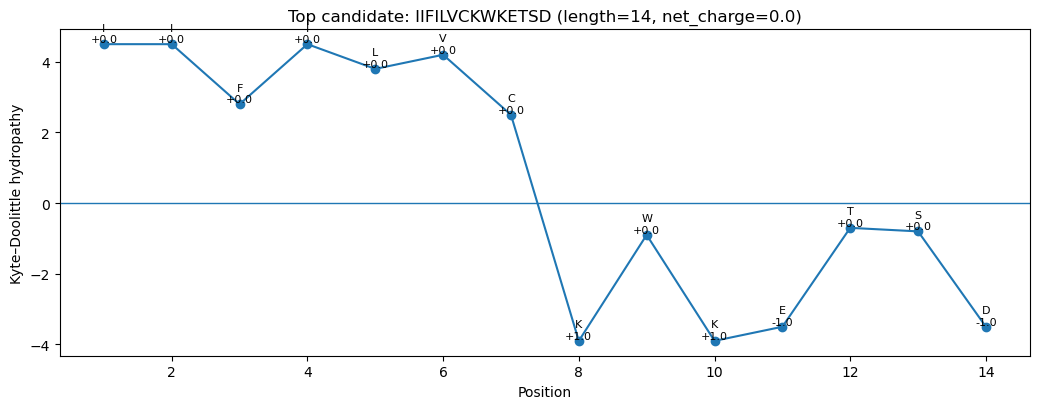

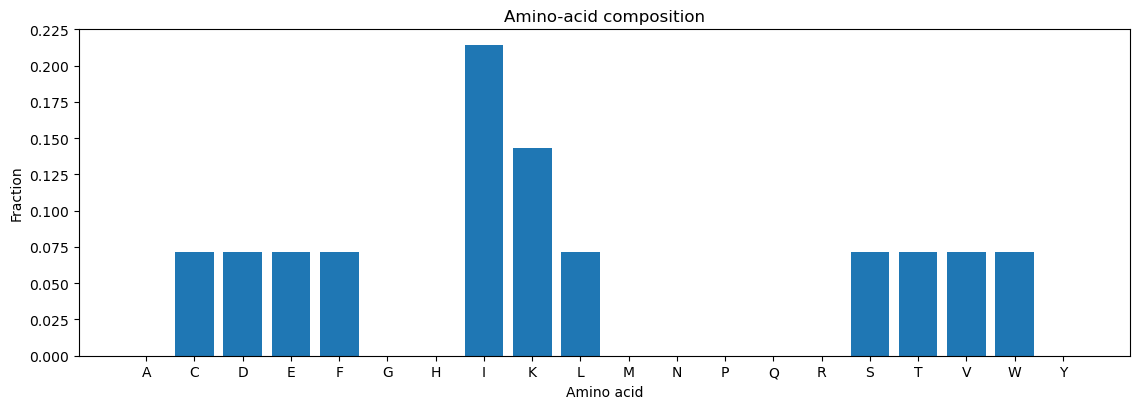

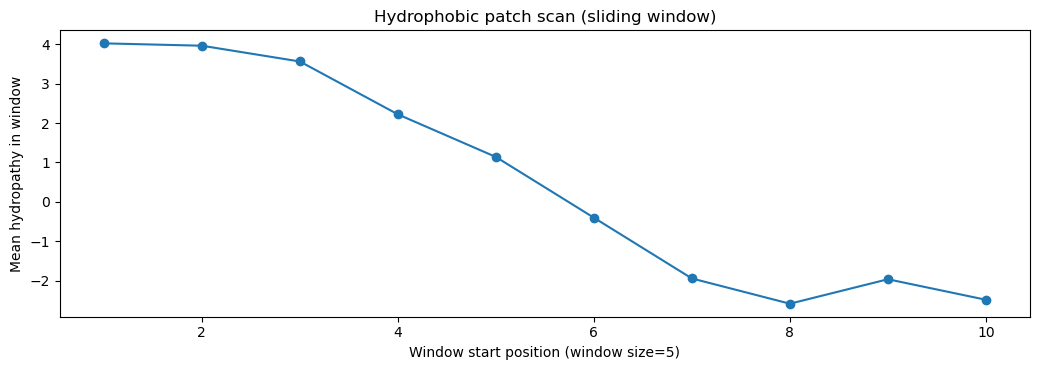

Property summary
- Sequence: IIFILVCKWKETSD
- Length: 14
- Net charge (proxy): 0.00
- Mean hydropathy: 0.69
- Hydrophobic fraction: 0.50
- Polar fraction: 0.14
- Aromatic fraction: 0.14

Liability flags: none triggered by the default rules.


In [38]:
import numpy as np
import matplotlib.pyplot as plt

TOP_SEQ = "IIFILVCKWKETSD"  # replace if needed

# ---- minimal fallbacks (safe if already defined) ----
try:
    AMINO_ACIDS
except NameError:
    AMINO_ACIDS = list("ACDEFGHIKLMNPQRSTVWY")

try:
    HYDROPATHY
except NameError:
    HYDROPATHY = {
        "A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
        "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
        "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
        "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3
    }

try:
    CHARGE
except NameError:
    CHARGE = {"D": -1, "E": -1, "K": +1, "R": +1, "H": +0.1}

try:
    AROMATIC
except NameError:
    AROMATIC = set("FWY")

try:
    POLAR
except NameError:
    POLAR = set("STNQH")

try:
    HYDROPHOBIC
except NameError:
    HYDROPHOBIC = set("AILMVFWY")

def _net_charge(seq: str) -> float:
    return float(sum(CHARGE.get(a, 0.0) for a in seq))

def _sliding_window_hydro(seq: str, win: int = 5) -> np.ndarray:
    if len(seq) < win:
        return np.array([], dtype=float)
    vals = []
    for i in range(len(seq) - win + 1):
        w = seq[i:i+win]
        vals.append(np.mean([HYDROPATHY[a] for a in w]))
    return np.asarray(vals, dtype=float)

def _liability_text(seq: str) -> str:
    # Mirrors the gate logic used earlier (deamidation hotspots, DP cleavage, oxidation, cysteine, extreme charge, aggregation proxy)
    flags = {}
    flags["deamidation_hotspot (NG/NS/QG/QN)"] = any(m in seq for m in ("NG","NS","QG","QN"))
    flags["Asp-Pro cleavage (DP)"] = ("DP" in seq)
    flags["oxidation risk (high M/W)"] = (seq.count("M") > 2 or seq.count("W") > 2)
    flags["cysteine risk (too many C)"] = (seq.count("C") > 1)
    flags["extreme net charge"] = (abs(_net_charge(seq)) > 4.0)

    hyd_frac = sum(1 for a in seq if a in HYDROPHOBIC) / max(1, len(seq))
    aro_frac = sum(1 for a in seq if a in AROMATIC) / max(1, len(seq))
    flags["aggregation proxy (high hydrophobic/aromatic)"] = (hyd_frac > 0.65 or aro_frac > 0.30)

    hit = [k for k,v in flags.items() if v]
    if not hit:
        return "Liability flags: none triggered by the default rules."
    return "Liability flags triggered:\n- " + "\n- ".join(hit)

# 1) Annotated sequence map (hydropathy + charge per position) 
seq = TOP_SEQ
pos = np.arange(1, len(seq)+1)
hyd = np.array([HYDROPATHY[a] for a in seq], dtype=float)
chg = np.array([CHARGE.get(a, 0.0) for a in seq], dtype=float)

fig = plt.figure(figsize=(10.5, 4.2))
ax = fig.add_subplot(111)
ax.plot(pos, hyd, marker="o")
ax.axhline(0.0, linewidth=1)
ax.set_xlabel("Position")
ax.set_ylabel("Kyte–Doolittle hydropathy")
ax.set_title(f"Top candidate: {seq} (length={len(seq)}, net_charge={_net_charge(seq):.1f})")

# overlay charge as text labels (small, readable)
for i, (p, aa, c) in enumerate(zip(pos, seq, chg)):
    ax.text(p, hyd[i], f"{aa}\n{c:+.1f}", ha="center", va="bottom", fontsize=8)

fig.tight_layout()
plt.show()

# 2) Amino-acid composition bar plot 
counts = np.array([seq.count(a) for a in AMINO_ACIDS], dtype=float)
freq = counts / max(1, len(seq))

fig = plt.figure(figsize=(11.5, 4.2))
ax = fig.add_subplot(111)
ax.bar(AMINO_ACIDS, freq)
ax.set_xlabel("Amino acid")
ax.set_ylabel("Fraction")
ax.set_title("Amino-acid composition")
fig.tight_layout()
plt.show()

# 3) Sliding window hydrophobicity (spot hydrophobic patches) 
win = 5
sw = _sliding_window_hydro(seq, win=win)

fig = plt.figure(figsize=(10.5, 3.8))
ax = fig.add_subplot(111)
if sw.size:
    ax.plot(np.arange(1, len(sw)+1), sw, marker="o")
    ax.set_xlabel(f"Window start position (window size={win})")
    ax.set_ylabel("Mean hydropathy in window")
    ax.set_title("Hydrophobic patch scan (sliding window)")
else:
    ax.text(0.5, 0.5, "Sequence shorter than window, no scan computed.", ha="center", va="center")
    ax.axis("off")
fig.tight_layout()
plt.show()

# 4) Simple property summary + liability flags 
hyd_frac = sum(1 for a in seq if a in HYDROPHOBIC) / max(1, len(seq))
pol_frac = sum(1 for a in seq if a in POLAR) / max(1, len(seq))
aro_frac = sum(1 for a in seq if a in AROMATIC) / max(1, len(seq))

print("Property summary")
print(f"- Sequence: {seq}")
print(f"- Length: {len(seq)}")
print(f"- Net charge (proxy): {_net_charge(seq):.2f}")
print(f"- Mean hydropathy: {hyd.mean():.2f}")
print(f"- Hydrophobic fraction: {hyd_frac:.2f}")
print(f"- Polar fraction: {pol_frac:.2f}")
print(f"- Aromatic fraction: {aro_frac:.2f}")
print()
print(_liability_text(seq))

# Visualize (draw) a peptide sequence as:
1) colored residue strip + liability motif highlights,
2) hydropathy + charge tracks along the sequence,
3) a simple helical-wheel style projection (100° per residue).

Works in a Jupyter notebook or as a .py script.
Dependencies: numpy, matplotlib

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Basic dictionaries (same as your platform)
HYDROPATHY = {
    "A": 1.8, "C": 2.5, "D": -3.5, "E": -3.5, "F": 2.8,
    "G": -0.4, "H": -3.2, "I": 4.5, "K": -3.9, "L": 3.8,
    "M": 1.9, "N": -3.5, "P": -1.6, "Q": -3.5, "R": -4.5,
    "S": -0.8, "T": -0.7, "V": 4.2, "W": -0.9, "Y": -1.3
}
CHARGE = {"D": -1.0, "E": -1.0, "K": +1.0, "R": +1.0, "H": +0.1}

AROMATIC = set("FWY")
POLAR = set("STNQH")
HYDROPHOBIC = set("AILMVFWY")
BASIC = set("KRH")
ACIDIC = set("DE")

LIABILITY_MOTIFS = ["NG", "NS", "QG", "QN", "DP"]  # deamidation hotspots + Asp-Pro cleavage


def residue_category(a: str) -> str:
    if a in ACIDIC:
        return "acidic"
    if a in BASIC:
        return "basic"
    if a in AROMATIC:
        return "aromatic"
    if a in POLAR:
        return "polar"
    if a == "C":
        return "cys"
    if a in HYDROPHOBIC:
        return "hydrophobic"
    return "other"


# Colors per category (feel free to tweak)
CAT_COLOR = {
    "hydrophobic": "#f4d03f",
    "polar": "#85c1e9",
    "acidic": "#ec7063",
    "basic": "#58d68d",
    "aromatic": "#af7ac5",
    "cys": "#f5b7b1",
    "other": "#d5dbdb",
}


def find_motif_hits(seq: str, motifs=LIABILITY_MOTIFS):
    hits = []
    for m in motifs:
        start = 0
        while True:
            i = seq.find(m, start)
            if i == -1:
                break
            hits.append((m, i, i + len(m)))  # [start, end)
            start = i + 1
    # merge overlaps for cleaner highlighting
    hits = sorted(hits, key=lambda x: (x[1], x[2]))
    merged = []
    for m, s, e in hits:
        if not merged or s > merged[-1][2]:
            merged.append([m, s, e])
        else:
            merged[-1][2] = max(merged[-1][2], e)
            merged[-1][0] = merged[-1][0] + "," + m
    return [(m, s, e) for m, s, e in merged]


def plot_residue_strip(seq: str, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(max(10, len(seq) * 0.45), 2.2))

    ax.set_xlim(0, len(seq))
    ax.set_ylim(0, 1)
    ax.axis("off")

    # Draw colored boxes per residue
    for i, a in enumerate(seq):
        cat = residue_category(a)
        rect = Rectangle((i, 0.15), 1.0, 0.7, facecolor=CAT_COLOR.get(cat, "#d5dbdb"), edgecolor="white")
        ax.add_patch(rect)
        ax.text(i + 0.5, 0.5, a, ha="center", va="center", fontsize=11, fontweight="bold")

    # Position labels
    for i in range(0, len(seq), 5):
        ax.text(i + 0.02, 0.02, str(i + 1), fontsize=9, ha="left", va="bottom")

    # Liability motif highlights
    hits = find_motif_hits(seq)
    for m, s, e in hits:
        ax.add_patch(Rectangle((s, 0.10), e - s, 0.80, fill=False, linewidth=2.2, edgecolor="black"))
        ax.text((s + e) / 2, 0.93, m, ha="center", va="bottom", fontsize=9)

    ax.set_title("Residue strip, colors by residue class, black boxes mark liability motifs (NG/NS/QG/QN/DP)", pad=8)


def plot_tracks(seq: str, ax1=None, ax2=None, window=5):
    x = np.arange(1, len(seq) + 1)
    hydro = np.array([HYDROPATHY.get(a, 0.0) for a in seq], dtype=float)
    charge = np.array([CHARGE.get(a, 0.0) for a in seq], dtype=float)
    cum_charge = np.cumsum(charge)

    # sliding mean hydropathy
    if len(seq) >= window:
        kernel = np.ones(window) / window
        hydro_smooth = np.convolve(hydro, kernel, mode="same")
    else:
        hydro_smooth = hydro.copy()

    if ax1 is None or ax2 is None:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

    # Hydropathy track
    ax1.plot(x, hydro, marker="o", linewidth=1)
    ax1.plot(x, hydro_smooth, linewidth=2)
    ax1.axhline(0.0, linewidth=1)
    ax1.set_ylabel("Hydropathy")
    ax1.set_title("Hydropathy along sequence (raw and smoothed)")
    ax1.legend(["Per-residue", f"Window={window} smooth"], loc="best")

    # Charge tracks
    ax2.bar(x, charge)
    ax2.plot(x, cum_charge, marker="o", linewidth=1.5)
    ax2.axhline(0.0, linewidth=1)
    ax2.set_xlabel("Residue position")
    ax2.set_ylabel("Charge / Cumulative charge")
    ax2.set_title("Charge per residue (bars) and cumulative net charge (line)")
    ax2.legend(["Cumulative charge"], loc="best")


def plot_helical_wheel(seq: str, ax=None, angle_deg=100.0):
    """
    Simple helical wheel projection:
    each residue i is placed at angle i*100° and radius increasing slightly to avoid overlap.
    This is a visualization aid, not a physical structure.
    """
    n = len(seq)
    angles = np.deg2rad(np.arange(n) * angle_deg)
    radii = 1.0 + 0.02 * np.arange(n)

    xs = radii * np.cos(angles)
    ys = radii * np.sin(angles)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6.8, 6.8))

    ax.set_aspect("equal", "box")
    ax.axis("off")

    # Draw a faint circle for reference
    t = np.linspace(0, 2 * np.pi, 300)
    ax.plot(np.cos(t), np.sin(t), linewidth=1, alpha=0.4)

    for i, a in enumerate(seq):
        cat = residue_category(a)
        ax.scatter(xs[i], ys[i], s=250, edgecolor="black", linewidth=0.6)
        ax.text(xs[i], ys[i], a, ha="center", va="center", fontsize=10, fontweight="bold")

    ax.set_title("Helical-wheel style projection (100° per residue), colored by residue class", pad=10)


def visualize_peptide(seq: str, outprefix: str = "top_candidate_visual"):
    seq = seq.strip().upper()
    if not seq or any(a not in HYDROPATHY for a in seq):
        raise ValueError("Sequence contains invalid amino acid letters, use standard 20 AA codes.")

    # Figure 1, residue strip + motifs
    fig1, ax = plt.subplots(figsize=(max(12, len(seq) * 0.45), 2.6))
    plot_residue_strip(seq, ax=ax)
    fig1.tight_layout()
    fig1.savefig(f"{outprefix}_strip.png", dpi=220)
    plt.close(fig1)

    # Figure 2, tracks
    fig2, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
    plot_tracks(seq, ax1=ax1, ax2=ax2, window=5)
    fig2.tight_layout()
    fig2.savefig(f"{outprefix}_tracks.png", dpi=220)
    plt.close(fig2)

    # Figure 3, helical wheel
    fig3, ax = plt.subplots(figsize=(7, 7))
    plot_helical_wheel(seq, ax=ax, angle_deg=100.0)
    fig3.tight_layout()
    fig3.savefig(f"{outprefix}_helical_wheel.png", dpi=220)
    plt.close(fig3)

    print("Saved:")
    print(f"  {outprefix}_strip.png")
    print(f"  {outprefix}_tracks.png")
    print(f"  {outprefix}_helical_wheel.png")


# Example: use your top candidate sequence here 
top_candidate = "IIFILVCKWVWKETSD"  # replace if needed
visualize_peptide(top_candidate, outprefix="top_candidate_IIFILVCKWVWKETSD")

Saved:
  top_candidate_IIFILVCKWVWKETSD_strip.png
  top_candidate_IIFILVCKWVWKETSD_tracks.png
  top_candidate_IIFILVCKWVWKETSD_helical_wheel.png
